# 📈 Model Evaluation on Test Data
This notebook evaluates a trained model on unseen test data, displaying classification reports, confusion matrices, and prediction visualizations.

---

### 🔧 Imports and Configurations

In [ ]:
# === Imports ===
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === Configuration Constants ===

# Distribution strategy (IID, non-IID etc.)
DISTRIBUTION = "IID"
MODEL_TYPE = "standalone" # global, standalone

# Test dataset
TEST_DIR = f"../../resources/material/train-data/federated/{DISTRIBUTION}-npy/test_clients"
LABEL_CSV = f"../../resources/material/train-data/federated/{DISTRIBUTION}/test_clients/labels.csv"
LABEL_MAP = {"bad": 0, "good": 1}
REVERSE_MAP = {0: "bad", 1: "good"}
LABELS = ["Good", "Bad"]

# Model
MODEL_PATH = f"../../model/global_model_standalone_{DISTRIBUTION}.h5"

# Plots
PLOT_DIR = f"../../resources/plot/{MODEL_TYPE}/test-data/{DISTRIBUTION}"
CONFUSION_MATRIX_PLOT_DIR = f"{PLOT_DIR}/confusion_matrix.png"
ROC_AUC_PLOT_DIR = f"{PLOT_DIR}/roc_auc.png"
PRECISION_RECALL_PLOT_DIR = f"{PLOT_DIR}/precision_recall.png"
PREDICTION_HISTOGRAM_PLOT_DIR = f"{PLOT_DIR}/prediction_histogram.png"
PER_CLASS_ACCURACY_PLOT_DIR = f"{PLOT_DIR}/per_class_accuracy.png"
F1_THRESHOLD_PLOT_DIR = f"{PLOT_DIR}/f1_threshold.png"
F1_EPOCH_PLOT_DIR = f"{PLOT_DIR}/f1_epoch.png"
PRECISION_RECALL_F1_ISOCURVS_PLOT_DIR = f"{PLOT_DIR}/precision_recall_curve_with_f1_isocurves.png"

os.makedirs(PLOT_DIR, exist_ok=True)

### 📘 Load and Preprocess Test Data

In [ ]:

def load_label_mapping(label_csv=LABEL_CSV, label_map=LABEL_MAP):
    df = pd.read_csv(label_csv)
    return {
        row["filename"].replace(".wav", ".npy"): label_map[row["label"].strip().lower()]
        for _, row in df.iterrows()
    }

def load_all_training_data(base_dir):
    all_data = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".npy"):
                data = np.load(os.path.join(root, file))
                data = data.flatten()  # ensure it's 1D per file
                all_data.append(data)
    
    all_data = np.concatenate(all_data, axis=0)
    return all_data

def load_test_data(test_dir=TEST_DIR):
    X, y, filenames = [], [], []
    label_dict = load_label_mapping()
    print(f"📂 Loading test data from: {test_dir}")
    
    for fname in os.listdir(test_dir):
        if fname.endswith(".npy") and fname in label_dict:
            try:
                features = np.load(os.path.join(test_dir, fname))
                X.append(features)
                y.append(label_dict[fname])
                filenames.append(fname)
            except Exception as e:
                print(f"❌ Failed to load {fname}: {e}")
        elif fname.endswith(".npy"):
            print(f"⚠️ Skipping {fname} — no label found.")
    
    return np.array(X), np.array(y), filenames

def normalize_features(X):
    """Normalize input features using mean and std from training set."""
    all_features = load_all_training_data(TEST_DIR)

    mean = np.mean(all_features)
    std = np.std(all_features)

    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)
    X = (X - mean) / std
    print(f"✅ Normalized features with mean={mean}, std={std}")
    return X

# === Load and Preprocess Test Data ===
X_test, y_test, filenames = load_test_data()
X_test = normalize_features(X_test)
print(f"🧪 Loaded {len(y_test)} test samples.")
print("📊 Class distribution:", dict(Counter(y_test)))

📂 Loading test data from: ../../resources/material/train-data/federated/IID-npy/test_clients
✅ Normalized features with mean=-5.812836170196533, std=14.956048011779785
🧪 Loaded 200 test samples.
📊 Class distribution: {0: 100, 1: 100}


### 🎯 Load & Evaluate model

In [ ]:
# === Load the Model ===
model = load_model(MODEL_PATH)
print(f"📦 Model loaded from {MODEL_PATH}")

# === Evaluate ===
def evaluate_model(model, X, y, filenames, reverse_map=REVERSE_MAP):
    # Predict
    y_pred_probs = model.predict(X, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

    # Accuracy and Report
    accuracy = accuracy_score(y, y_pred)
    print(f"✅ Accuracy: {accuracy*100:.2f}%")
    print("\n📄 Classification Report:\n", classification_report(y, y_pred, target_names=["bad", "good"]))

    # Per-sample results
    print("\n🔍 Prediction Details:")
    for fname, true, pred in zip(filenames, y, y_pred):
        status = "✅" if true == pred else "❌"
        print(f"{status} {fname} → True: {reverse_map[true]}, Predicted: {reverse_map[pred]}")

    return y_pred

y_pred = evaluate_model(model, X_test, y_test, filenames)

📦 Model loaded from ../../model/global_model_standalone_IID.h5
✅ Accuracy: 96.50%

📄 Classification Report:
               precision    recall  f1-score   support

         bad       0.93      1.00      0.97       100
        good       1.00      0.93      0.96       100

    accuracy                           0.96       200
   macro avg       0.97      0.97      0.96       200
weighted avg       0.97      0.96      0.96       200


🔍 Prediction Details:
✅ bad_tap_604_aug_592.npy → True: bad, Predicted: bad
✅ bad_tap_1048_org.npy → True: bad, Predicted: bad
✅ good_tap_679_aug_1404.npy → True: good, Predicted: good
✅ bad_tap_176_aug_574.npy → True: bad, Predicted: bad
✅ bad_tap_1219_aug_346.npy → True: bad, Predicted: bad
✅ bad_tap_802_aug_8274.npy → True: bad, Predicted: bad
✅ good_tap_695_aug_553.npy → True: good, Predicted: good
✅ good_tap_1146_aug_2603.npy → True: good, Predicted: good
✅ bad_tap_640_aug_6912.npy → True: bad, Predicted: bad
✅ bad_tap_570_aug_885.npy → True: bad, Pred

### 📊 Confusion Matrix Plot

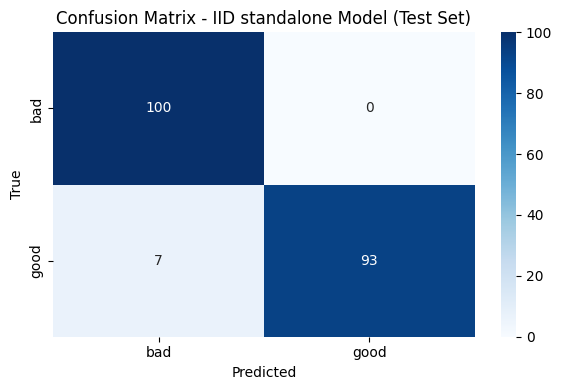

📸 Saved confusion matrix to: ../../resources/plot/standalone/IID/confusion_matrix.png


In [ ]:
# === Confusion Matrix Plot ===
def plot_confusion_matrix(y_true, y_pred, title, save_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["bad", "good"], yticklabels=["bad", "good"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"📸 Saved confusion matrix to: {save_path}")

plot_confusion_matrix(y_test, y_pred, f"Confusion Matrix - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)", CONFUSION_MATRIX_PLOT_DIR)

### 📊 ROC Curve 

7/7 [==============================] - 0s 1ms/step


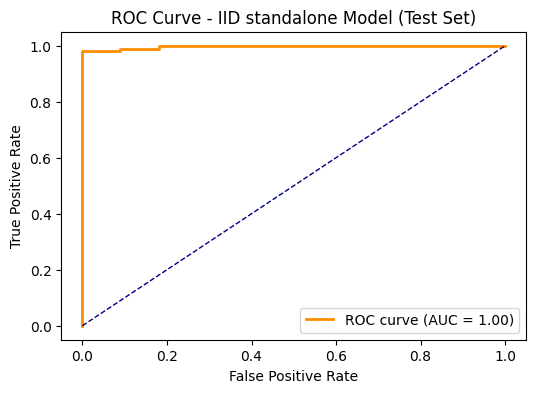

In [29]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_pred_prob, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.legend(loc="lower right")
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Predict probabilities
y_pred_probs = model.predict(X_test).flatten()

# Run plots
plot_roc(y_test, y_pred_probs, ROC_AUC_PLOT_DIR)

### 📊  Precision-Recall Curve

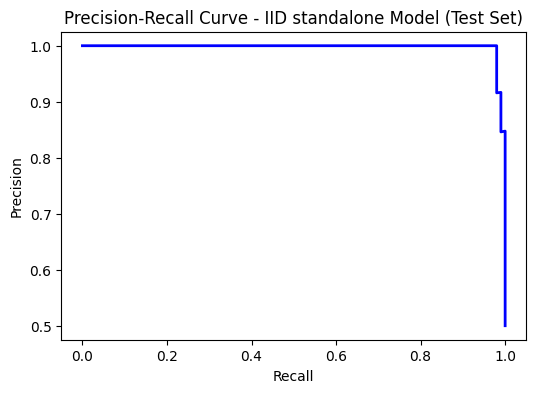

In [30]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(y_true, y_pred_prob, save_path=None):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_precision_recall(y_test, y_pred_probs, PRECISION_RECALL_PLOT_DIR)

### 📊  Prediction Score Distribution

7/7 [==============================] - 0s 1ms/step


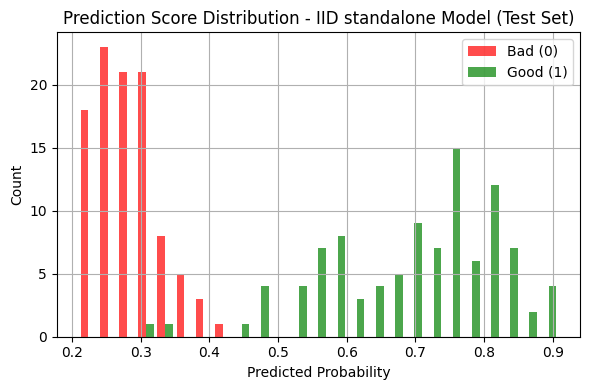

In [31]:
# Predicted probabilities from model
y_probs = model.predict(X_test).flatten()
def plot_prediction_histogram(y_probs, y_true, save_path=None):
    plt.figure(figsize=(6, 4))
    plt.hist([y_probs[y_true == 0], y_probs[y_true == 1]],
             bins=25, label=['Bad (0)', 'Good (1)'], color=['red', 'green'], alpha=0.7)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title(f"Prediction Score Distribution - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_prediction_histogram(y_probs, y_test, PREDICTION_HISTOGRAM_PLOT_DIR)

### 📊  Per-Class Accuracy

/var/folders/9_/0r_f3kw13_zg23k72mwhdmp558319r/T/ipykernel_5226/3742497395.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=accuracies, palette="Set2")


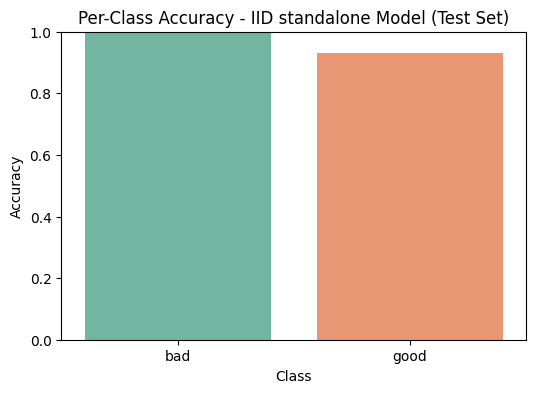

In [32]:
def plot_per_class_accuracy(y_true, y_pred, save_path=None):
    labels = np.unique(y_true)
    accuracies = [
        np.mean(y_pred[y_true == label] == label) for label in labels
    ]
    label_names = [REVERSE_MAP[l] for l in labels]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=label_names, y=accuracies, palette="Set2")
    plt.ylim(0, 1)
    plt.title(f"Per-Class Accuracy - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.ylabel("Accuracy")
    plt.xlabel("Class")
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_per_class_accuracy(y_test, y_pred, PER_CLASS_ACCURACY_PLOT_DIR)

### 📊  F1 Score vs Threshold

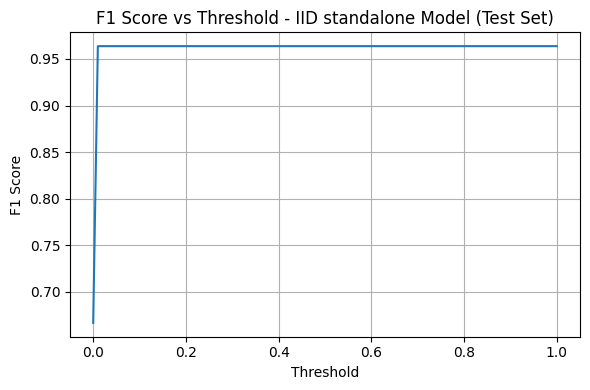

In [33]:
from sklearn.metrics import f1_score

def plot_f1_vs_threshold(y_true, y_probs,save_path=None):
    thresholds = np.arange(0.0, 1.01, 0.01)
    f1_scores = [f1_score(y_true, y_probs >= t) for t in thresholds]
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, f1_scores)
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score vs Threshold - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_f1_vs_threshold(y_test, y_pred, F1_THRESHOLD_PLOT_DIR)

### 📊  Validation F1 Score over Epochs

Epoch 1/30
2/2 [==============================] - 0s 2ms/steposs: 0.2845 - accuracy: 1.00
— epoch: 1, val_f1: 0.9189
5/5 [==============================] - 1s 84ms/step - loss: 0.3166 - accuracy: 0.9125 - val_loss: 0.2406 - val_accuracy: 0.9250
Epoch 2/30
2/2 [==============================] - 0s 2ms/steposs: 0.2725 - accuracy: 0.93
— epoch: 2, val_f1: 0.9268
5/5 [==============================] - 0s 33ms/step - loss: 0.2705 - accuracy: 0.9312 - val_loss: 0.2146 - val_accuracy: 0.9250
Epoch 3/30
2/2 [==============================] - 0s 4ms/steposs: 0.1341 - accuracy: 1.00
— epoch: 3, val_f1: 1.0000
5/5 [==============================] - 0s 40ms/step - loss: 0.2864 - accuracy: 0.8938 - val_loss: 0.1599 - val_accuracy: 1.0000
Epoch 4/30
2/2 [==============================] - 0s 2ms/steposs: 0.2744 - accuracy: 0.87
— epoch: 4, val_f1: 0.9474
5/5 [==============================] - 0s 36ms/step - loss: 0.3577 - accuracy: 0.8438 - val_loss: 0.1795 - val_accuracy: 0.9500
Epoch 5/30
2/2 [====

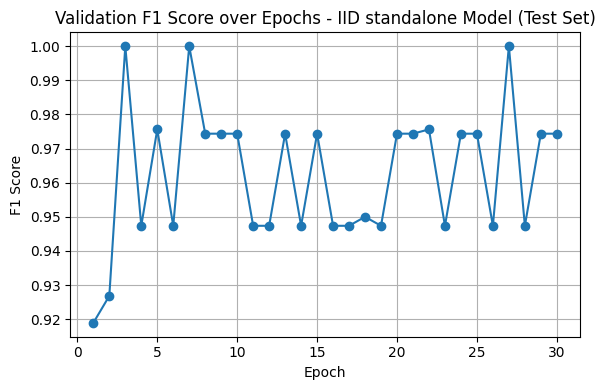

In [ ]:
from sklearn.metrics import f1_score
import tensorflow as tf

from sklearn.model_selection import train_test_split

# Assuming X and y are your full dataset and labels
X_train, X_val, y_train, y_val = train_test_split(
    X_test, y_test, test_size=0.2, random_state=42, stratify=y_test
)

class F1History(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_probs = self.model.predict(self.X_val).flatten()
        y_pred = (y_pred_probs >= 0.5).astype(int)
        f1 = f1_score(self.y_val, y_pred)
        self.f1_scores.append(f1)
        print(f"— epoch: {epoch + 1}, val_f1: {f1:.4f}")

f1_callback = F1History(X_val, y_val)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[f1_callback]
)


def plot_f1_over_epochs(f1_scores, save_path=None):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
    plt.title(f"Validation F1 Score over Epochs - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_f1_over_epochs(f1_callback.f1_scores, F1_EPOCH_PLOT_DIR)


### 📊  Precision-Recall Curve

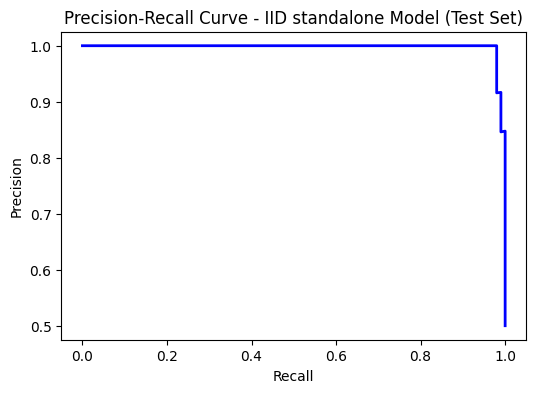

In [35]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(y_true, y_pred_prob, save_path=None):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_precision_recall(y_test, y_pred_probs, ROC_AUC_PLOT_DIR)

### 📊  Precision-Recall Curve with F1 Isocurves

2/2 [==============================] - 0s 2ms/step


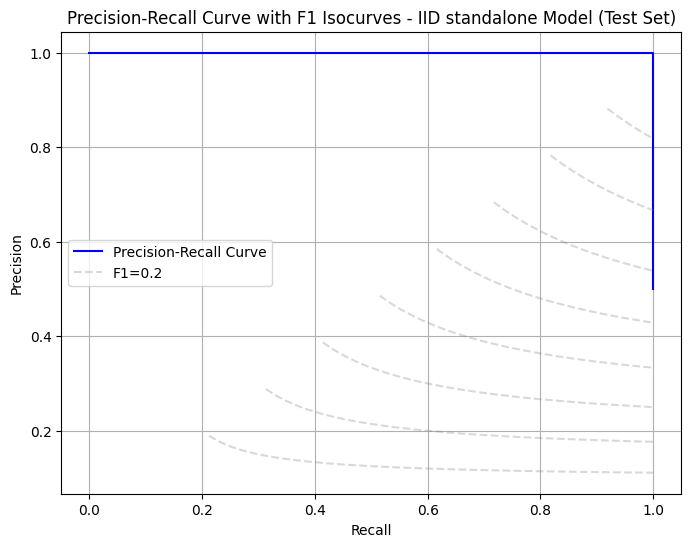

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

# y_true = actual labels
# y_probs = predicted probabilities from model.predict(X)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Assuming X and y are your full dataset and labels
X_train, X_val, y_train, y_val = train_test_split(
    X_test, y_test, test_size=0.2, random_state=42, stratify=y_test
)

def plot_pr_with_f1_isocurves(y_true, y_probs):
    from sklearn.metrics import precision_recall_curve

    precision, recall, _ = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=(8, 6))

    # 🔷 PR Curve
    plt.plot(recall, precision, color="blue", label="Precision-Recall Curve")

    # 🟠 F1 Isocurves
    f_scores = np.linspace(0.2, 0.9, num=8)
    for f in f_scores:
        x = np.linspace(0.01, 1)
        y = (f * x) / (2 * x - f + 1e-9)
        y[x < f] = np.nan  # avoid invalid values
        plt.plot(x, y, color="gray", alpha=0.3, linestyle="--", label=f"F1={f:.1f}" if f == f_scores[0] else None)

    # 🧭 Labels & Legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve with F1 Isocurves - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

y_probs = model.predict(X_val).ravel()  # predicted probabilities
plot_pr_with_f1_isocurves(y_val, y_probs)
